# Redukcja wymiarów wprowadzenie 

Często w wypadku analiz danych możemy spotkać się z dużą liczbą zmiennych opisujących nasze obserwacje. Dużo danych nie znaczy jednak dużo informacji i taki stan rzeczy może naszą analizę tylko utrudniać. W takich wypadkach na pomoc przychodzą techniki związane z redukcją wymiarów.

W ich ramach staramy się zredukować liczbę zmiennych w zbiorze, lub stworzyć nowe, sysntetyczne zmienne, które zawierąją w sobie jak najwięcej informacji ze zmiennych pierwotnych.

Takie podejście jest pomocne:
- w radzeniu sobie z wieloliniowościę (multicolinerity)
- w zarządzaniu przeklęstwem wielowymiarowości
- w budowaniu lepszych skupień
- w wizulizacji danych w ramach EDA
- w wnioskowaniu z danych

# Analiza głównych skladowych (PCA)

Najbardziej popularną z metod redukcji wymiarów jest Principal Component Analysis. Jej główną idą jest mapowanie naszych zmiennych na nowy układ współrzędnych, takich że, wzdłuż pierwszego wymiary zawiera się najwięcej wariancji naszych danych, wzdłuż drugiego mniej, ale więcej niż wzdłuż trzeciego etc.

Wartości punktów w nowym układzie współrzędnych nazywane są głównymi składowymi. Widzieć je możemy też jako kombinacje liniowe pierwotnych zmiennych.

W procesie analizy pozbywamy się najczęsciej składowych położonych najniżej w "rankingu" osi. Nowym osią możemy nadać też intrpetacje odnoszące się do pierwotnych zmiennych.

Zobaczmy to wizualnie:
https://setosa.io/ev/principal-component-analysis/#:~:text=Principal%20component%20analysis%20(PCA)%20is,easy%20to%20explore%20and%20visualize.

# Zobaczmy jak to działa na irysach

Ładowanie danych

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

In [ ]:
iris = load_iris()

df= pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                 columns= iris['feature_names'] + ['target'])

df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

## Wizualizacje

In [ ]:
import plotly.express as px

features = ["sepal width (cm)", "sepal length (cm)", "petal width (cm)", "petal length (cm)"]

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="species"
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import plotly.graph_objs as go

corr = df[features].corr()

trace = go.Heatmap(z=corr.values,
           x=corr.index.values,
           y=corr.columns.values)

go.Figure(trace)

## PCA od podstaw

W tej części od podstaw dokonamy redukcji wymiarowości przez metodę głównych składowych.

Mamy teraz dwie równoważne możliwości:
* dokonujemy dekompozycji macierzy korelacji
* dokonujemy dekompozycji macierzy kowariancji na ustandaryzowanych danych

Dla dociekliwych dyskusja o tych dwóch podejściach: https://stats.stackexchange.com/a/78

<font size="1">Należy pamiętać o transpozycji jeśli jest wymagana. Funkcje np.corrcoef, i np.cov przyjmują macierze, w których wiersze to zmienne</font>

In [ ]:
iris = df[features]

In [ ]:
# macierz korelacji
corr_matrix = np.corrcoef(iris.T)
corr_matrix

array([[ 1.        , -0.11756978, -0.36612593, -0.4284401 ],
       [-0.11756978,  1.        ,  0.81794113,  0.87175378],
       [-0.36612593,  0.81794113,  1.        ,  0.96286543],
       [-0.4284401 ,  0.87175378,  0.96286543,  1.        ]])

In [ ]:
srednie = np.mean(iris) # średnie wartości zmiennych
odchylenia = np.std(iris, ddof=1) # odchylenia standardowe zmiennych

iris_standardized = (iris - srednie) / odchylenia # 
np.cov(iris_standardized.T)

array([[ 1.        , -0.11756978, -0.36612593, -0.4284401 ],
       [-0.11756978,  1.        ,  0.81794113,  0.87175378],
       [-0.36612593,  0.81794113,  1.        ,  0.96286543],
       [-0.4284401 ,  0.87175378,  0.96286543,  1.        ]])

Dokonaj dekompozycji macierzy korelacji (bądź kowariancji) za pomocą funkcji: <br>
`numpy.linalg.eig(a)` <br>
Zwraca: <br>
`w The eigenvalues, each repeated according to its multiplicity. ` <br>
`v The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]`

<font size="1">https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html</font>

In [ ]:
dekompozycja = np.linalg.eig(corr_matrix)
wartosci_wlasne = dekompozycja[0]
wektory_wlasne = dekompozycja[1]
print('Wartości własne: {}'.format(wartosci_wlasne))
print('Wektory własne: {}'.format(wektory_wlasne))

Wartości własne: [2.91849782 0.91403047 0.14675688 0.02071484]
Wektory własne: [[ 0.26934744 -0.92329566  0.24438178  0.12350962]
 [-0.52106591 -0.37741762 -0.71956635 -0.26128628]
 [-0.56485654 -0.06694199  0.63427274 -0.52359713]
 [-0.5804131  -0.02449161  0.14212637  0.80144925]]


Procent wyjaśnianej wariancji przez poszczególne składowe możemy obliczyć jako wartość własną odpowiadającą danej składowej podzieloną przez sumę wszystkich wartości własnych.

<font size=1>Należy w razie potrzeby uporządkować wektory własne według malejących wartości własnych</font>

In [ ]:
wyjasniane_war = wartosci_wlasne / np.sum(wartosci_wlasne)
print(wyjasniane_war)

[0.72962445 0.22850762 0.03668922 0.00517871]


Zaprezentuj udziały wyjaśnianych wariancji na wykresie:

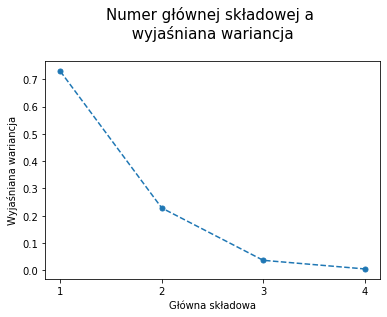

In [ ]:
from matplotlib import pyplot as plt

plt.plot([1,2,3,4], wyjasniane_war, ls='--', marker='.', ms=10)
plt.xticks(np.arange(1,5, 1.0)) # etykiety osi poziomej w przyjaznej formie
plt.ylabel('Wyjaśniana wariancja')
plt.xlabel('Główna składowa')
plt.title('Numer głównej składowej a \n wyjaśniana wariancja \n', size=15)
plt.show()

Obliczmy macierz ładunków:
$ Ładunki = Wektory własne * \sqrt{wartości  własne}$


In [ ]:
macierz_ladunkow = wektory_wlasne * np.sqrt(wartosci_wlasne)
print(macierz_ladunkow)

[[ 0.46014271 -0.88271627  0.09361987  0.01777631]
 [-0.89016876 -0.36082989 -0.27565767 -0.03760602]
 [-0.96497896 -0.06399985  0.24298265 -0.0753595 ]
 [-0.99155518 -0.02341519  0.05444699  0.11534978]]


In [ ]:
ramka_ladunkow = pd.DataFrame(
    macierz_ladunkow, columns=['Skladowa{}'.format(i) for i in range(1,5)],
    index=iris.columns
)
ramka_ladunkow

,Skladowa1,Skladowa2,Skladowa3,Skladowa4
sepal width (cm),0.460143,-0.882716,0.093620,0.017776
sepal length (cm),-0.890169,-0.360830,-0.275658,-0.037606
petal width (cm),-0.964979,-0.064000,0.242983,-0.075360
petal length (cm),-0.991555,-0.023415,0.054447,0.115350


Na bazie wykresów można przyjąć, że dwie główne składowe wyjaśnianiją wystarczająco dużo wariancji. Zredukujemy liczbę wymiarów do dwóch. Na początek stwórzmy macierz przekształcenia $W$ - kolumny są w niej więc dwoma pierwszymi wektorami własnymi

In [ ]:
macierz_przeksztalcen = wektory_wlasne[:,0:2]
print(macierz_przeksztalcen)

[[ 0.26934744 -0.92329566]
 [-0.52106591 -0.37741762]
 [-0.56485654 -0.06694199]
 [-0.5804131  -0.02449161]]


Obserwacje przekształcone do dwóch wymiarów uzyskamy mnożąc macierz zawierającą zestandaryzowane dane w oryginalnej przestrzeni przez macierz przekształceń.
\begin{equation*}
Y = X W
\end{equation*}
Pomocna będzie funkcja `np.dot`. Pamiętaj, że w przypadku macierzy kolejność mnożenia ma znaczenie.

Zróbmy z tego nową ramkę danych *new_data* o kolumnach:
* Skladowa1
* Skladowa2

In [ ]:
new_data = pd.DataFrame(
    np.dot(iris_standardized, macierz_przeksztalcen),
    columns=['Skladowa1', 'Skladowa2']
)

# hint - dla większej liczby składowych nazwy kolumn można wygenerować za pomocą mechanizmu 'list comprehension':
#['Skladowa{}'.format(i) for i in range(1,3)]

Narysujmy

In [ ]:
fig = px.scatter(new_data, x='Skladowa1', y='Skladowa2', color=df['species'])
fig.show()

In [ ]:
new_data

,Skladowa1,Skladowa2
0,2.257141,-0.478424
1,2.074013,0.671883
2,2.356335,0.340766
3,2.291707,0.595400
4,2.381863,-0.644676
...,...,...
145,-1.864258,-0.385674
146,-1.559356,0.893693
147,-1.516091,-0.268171
148,-1.368204,-1.007878


## sklearn

In [ ]:
from sklearn.decomposition import PCA

Definiujemy model (musimy podać liczbę głównych składowych)

In [ ]:
model_pca = PCA(n_components=2)

Przekształcamy na danych zestandaryzowanych:

In [ ]:
new_data_sklearn = model_pca.fit_transform(iris_standardized)
print(new_data_sklearn)

[[-2.25714118  0.47842383]
 [-2.07401302 -0.67188269]
 [-2.35633511 -0.34076642]
 [-2.29170679 -0.59539986]
 [-2.3818627   0.64467566]
 [-2.06870061  1.4842053 ]
 [-2.43586845  0.04748512]
 [-2.22539189  0.222403  ]
 [-2.32684533 -1.1116037 ]
 [-2.17703491 -0.46744757]
 [-2.15907699  1.04020587]
 [-2.31836413  0.132634  ]
 [-2.2110437  -0.72624318]
 [-2.62430902 -0.95829635]
 [-2.19139921  1.85384655]
 [-2.25466121  2.67731523]
 [-2.20021676  1.47865573]
 [-2.18303613  0.48720613]
 [-1.89223284  1.40032757]
 [-2.33554476  1.1240836 ]
 [-1.90793125  0.40749058]
 [-2.19964383  0.92103587]
 [-2.76508142  0.4568133 ]
 [-1.81259716  0.08527285]
 [-2.21972701  0.13679618]
 [-1.9453293  -0.62352971]
 [-2.04430277  0.24135499]
 [-2.1613365   0.52538942]
 [-2.13241965  0.312172  ]
 [-2.25769799 -0.33660425]
 [-2.13297647 -0.50285608]
 [-1.82547925  0.42228039]
 [-2.60621687  1.78758727]
 [-2.43800983  2.1435468 ]
 [-2.10292986 -0.45866527]
 [-2.20043723 -0.20541922]
 [-2.03831765  0.65934923]
 

Wartości własne możemy uzyskać z właściwości `.explained_variance_`, natomiast % wyjaśnianej wariancji z właściwości `.explained_variance_ratio_`

In [ ]:
model_pca.explained_variance_

array([2.91849782, 0.91403047])

In [ ]:
model_pca.explained_variance_ratio_

array([0.72962445, 0.22850762])

... oraz wektory własne za pomocą `.components_`

In [ ]:
model_pca.components_

array([[-0.26934744,  0.52106591,  0.56485654,  0.5804131 ],
       [ 0.92329566,  0.37741762,  0.06694199,  0.02449161]])

<font size=2>Czasami wyniki dla dekompozycji macierzy kowariancji i mechanizmu sklearna mogą się różnić w kwestii znaku przed wektorami własnymi - sklearn pod spodem używa mechanizmu *Singular Value Decomposition*. Dla analizy nie ma to istotnego znaczenia. Dla dociekliwych: https://stackoverflow.com/a/44847053</font>

Pełna wizualizacja w plotly

In [ ]:
loadings = model_pca.components_.T * np.sqrt(model_pca.explained_variance_)

fig = px.scatter(new_data_sklearn, x=0, y=1, color=df['species'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

## PCA - boston

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

df = pd.DataFrame(data= boston['data'], columns= boston['feature_names'])

In [ ]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Proszę policzyć macierz korelacji

In [ ]:
import plotly.graph_objs as go

corr = df.corr()

trace = go.Heatmap(z=corr.values,
           x=corr.index.values,
           y=corr.columns.values)

go.Figure(trace)

Proszę policzyć model PCA i spróbować podjąć decyzję ile skladowych powinnśmy zatrzymać.



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_stand = scaler.fit_transform(df)

In [ ]:
model_pca = PCA(n_components=13)

In [ ]:
new_boston = model_pca.fit_transform(df_stand)

In [ ]:
model_pca.explained_variance_ratio_

array([0.47129606, 0.11025193, 0.0955859 , 0.06596732, 0.06421661,
       0.05056978, 0.04118124, 0.03046902, 0.02130333, 0.01694137,
       0.0143088 , 0.01302331, 0.00488533])

In [ ]:
px.line(model_pca.explained_variance_ratio_, y = 0)

Proszę wyznaczyć i spróbować zinterpretować ładunki

In [ ]:
pd.DataFrame(model_pca.components_.T * np.sqrt(model_pca.explained_variance_), index=boston["feature_names"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
CRIM,0.621781,-0.377792,0.275126,0.057260,0.075140,-0.178278,0.569523,0.096609,0.137167,0.009099,-0.047336,0.035734,0.011592
ZN,-0.635070,-0.387452,0.330127,0.119312,0.293232,-0.262465,-0.201408,-0.253683,0.188658,0.125673,0.113437,-0.029418,-0.020413
INDUS,0.858948,0.134809,-0.017793,0.015894,-0.007144,-0.061794,-0.248707,0.109574,0.339462,-0.170773,-0.130884,-0.046624,-0.063337
CHAS,0.012494,0.545058,0.323346,0.756353,0.079140,0.135936,0.054298,-0.015537,-0.007231,-0.002904,0.006012,-0.001640,0.009062
NOX,0.849484,0.262584,0.134975,-0.118862,0.125164,-0.124162,-0.146213,0.050475,-0.009757,0.108541,0.048059,0.331278,0.011006
RM,-0.468886,0.178956,0.662760,-0.260100,-0.387279,0.048102,0.046830,-0.205849,0.025231,-0.202664,0.022951,0.062964,0.011495
AGE,0.777181,0.373868,-0.019722,-0.162411,0.015265,-0.058200,0.084967,-0.378510,-0.035590,0.170419,-0.198229,-0.087290,-0.009725
DIS,-0.796688,-0.418318,-0.055497,0.199703,0.090171,0.019023,-0.076097,-0.076740,-0.080750,-0.080429,-0.300345,0.161018,-0.004616
RAD,0.792350,-0.325385,0.320528,0.122684,-0.186696,-0.116218,-0.101030,0.050625,-0.248053,0.010292,0.015777,-0.044081,-0.159804
TAX,0.838624,-0.286956,0.246313,0.095789,-0.119318,-0.156587,-0.230625,0.052147,-0.093009,-0.016521,-0.045260,-0.088631,0.181686


Proszę narysować wykresy zależności naszych PC od siebie

In [ ]:
labels = {str(i): f"PC {i+1}" for i in range(4)}
labels['color'] = 'Median Price'

fig = px.scatter_matrix(
    new_boston,
    color=boston.target,
    dimensions=range(4),
    labels=labels,
)
fig.update_traces(diagonal_visible=False)
fig.show()
